# Inital Data Analysis

In [2]:
import os

import pandas as pd
import bokeh.plotting as bp
from bokeh.models import DatetimeTickFormatter
from bokeh.io import output_notebook, show
import matplotlib.pyplot as plt



from fault_management_uds.data.bellinge import load_timeseries_data, custom_ffill, add_time_feature

from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR

Matplotlib is building the font cache; this may take a moment.
2024-09-18 12:33:17.487 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


In [3]:

sensor_path = RAW_DATA_DIR / 'bellinge' / 'sensor-data'
cleaned_path = sensor_path / '2_cleaned_data'
rain_path = RAW_DATA_DIR / 'bellinge' / 'rain-gauge-data' / '#3a_Raingauges'

# DHI
DHI_path = EXTERNAL_DATA_DIR / 'DHI'
cleaned_path_DHI = DHI_path / 'data' / 'Bellinge' / '2_Sensor_data' / 'cleaned_data'
rain_path_DHI = DHI_path / 'data' / 'Bellinge'


Sensor data

In [4]:
structure = 'G71F05R'
sensor = 'LevelInlet'
startdate = '01-05-2017'
enddate = '01-05-2018'
df = load_timeseries_data(cleaned_path, structure=structure, sensor=sensor, startdate=startdate, enddate=enddate)
# the DHI data does not have data for year 2021

In [5]:
print(df.shape)
print(df.columns)
df.head(5)

(527040, 11)
Index(['raw_value', 'value_no_errors', 'man_remove', 'ffill', 'stamp',
       'outbound', 'frozen', 'outlier', 'depth_s', 'level', 'frozen_high'],
      dtype='object')


,raw_value,value_no_errors,man_remove,ffill,stamp,outbound,frozen,outlier,depth_s,level,frozen_high
2017-01-05 00:00:00,0.275,0.275,False,False,False,False,False,False,0.275,18.665,False
2017-01-05 00:01:00,0.274,0.274,False,False,False,False,False,False,0.274,18.664,False
2017-01-05 00:02:00,0.275,0.275,False,False,False,False,False,False,0.275,18.665,False
2017-01-05 00:03:00,0.274,0.274,False,False,False,False,False,False,0.274,18.664,False
2017-01-05 00:04:00,0.274,0.274,False,False,False,False,False,False,0.274,18.664,False


In [6]:
df.sum()

raw_value              148294.508
value_no_errors        148046.468
man_remove                      0
ffill                           0
stamp                           0
outbound                       40
frozen                        936
outlier                         0
depth_s             148217.281311
level              9675837.211311
frozen_high                     0
dtype: object

Rain data

In [7]:
# load kmd file as csv
rain = pd.read_csv(rain_path / '5425_ts.txt', sep=';', index_col = 0, parse_dates=True, skiprows=1)
"""
The metric is: Rainfall Intensity[mu-m/sec]:Mean_Step_Accumulated
i.e. micrometers per second (μm/sec) on average over the time step (1 minute)
"""

# impute 0 for missing minutes
rain = rain.resample('min').asfreq().fillna(0)

# rain = pd.read_csv(rain_path_DHI / 'rain_5.csv.gz', index_col = 0, parse_dates=True, compression='gzip')
# # compare rain and rain1
# rain.equals(rain1)

In [8]:
# add rain to dataframe
df = df.join(rain, how='left')  

Pipeline

In [9]:
important_col = "depth_s"
df = custom_ffill(df, important_col)
df[important_col].isna().sum()

np.int64(8265)

In [10]:
df = add_time_feature(df)
df[important_col].isna().sum()

np.int64(8265)

In [35]:

def Plot_datawash(data, structure, sensor):
    # Ensure data has a datetime index
    if 'time' not in data.columns and str(data.index.dtype) == 'datetime64[ns]':
        data.index.name = 'time'
        data = data.reset_index()
    else:
        raise ValueError('The data must have a datetime index')

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 8))

    # Define categories for plotting
    categories = {
        #'raw_value': ('grey', 4, structure, 'scatter'),
        'depth_s': ('black', 4, structure, 'line'),
        'stamp': ('blue', 20, 'stamp', 'true'),
        'outbound': ('red', 20, 'outbound', 'true'),
        'frozen': ('green', 40, 'frozen', 'true'),
        'man_remove': ('pink', 40, 'manual remove', 'true'),
        'outlier': ('violet', 40, 'single outlier', 'true'),
    }

    # Plot each category
    for category, (color, size, label, plottype) in categories.items():
        
        if plottype == 'line':
            ax.plot(data['time'], data['raw_value'], color=color, label=label)
        elif plottype == 'scatter':
            ax.scatter(data['time'], data['raw_value'], s=size, color=color, label=label)


        elif plottype == 'true':
            ax.scatter(
                data.loc[data[category], 'time'], 
                data.loc[data[category], 'raw_value'], 
                s=size, color=color, label=label
            )
    # Format plot
    ax.set(title=f'{structure} - {sensor}', xlabel='Time', ylabel='Raw value')
    fig.autofmt_xdate()
    ax.legend()

    plt.show()

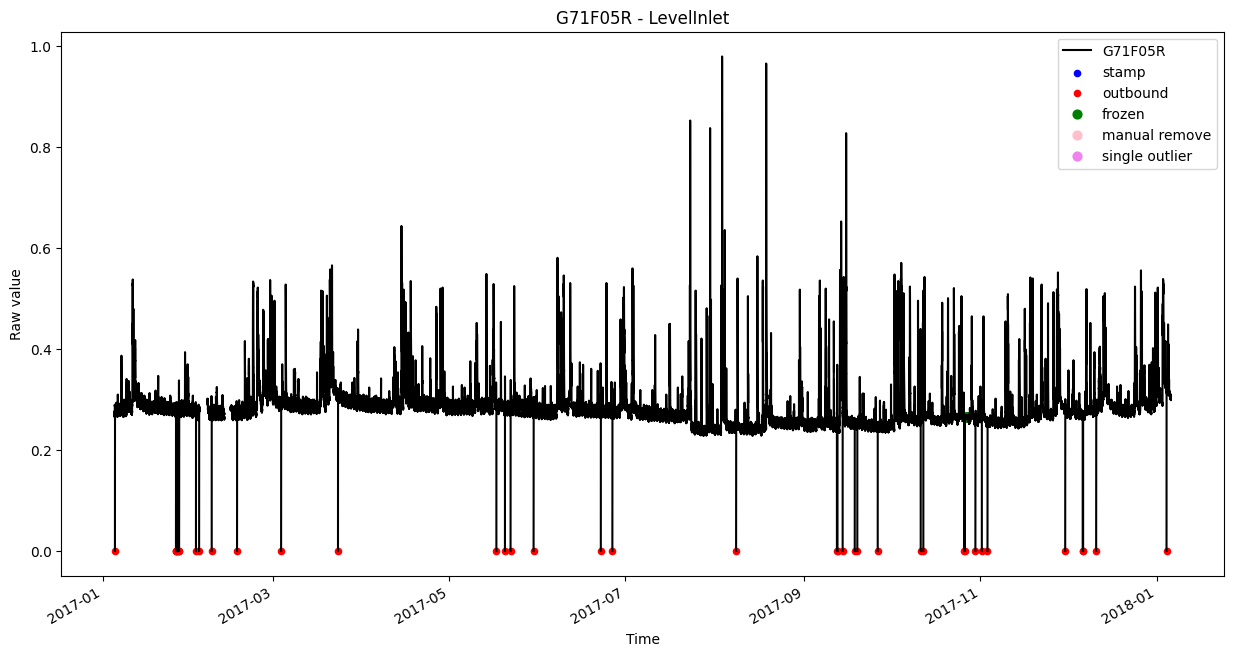

In [36]:
Plot_datawash(df, structure, sensor)